# Reduced dynamic multi-armed bandit problem with known reward probabilities

Here we will consider a simplified problem in which the reward probabilities are known to agents, however their distribution over arms is not known. In other words, the agent is aware of the reward probabilities of the best arm (and all other arms), but it does not known which arm is associated with the highest reward probability. At each time step the arm associated with the highest reward probability would either stay unchanged with probability $1-\rho$ or associated with another randomly selected arm with with probability $\rho$.

The highest reward probability will be set to $p_{max} = \epsilon + \frac{1}{2}$ and all other arms will be associated with $p=\frac{1}{2}$. This way three parameters define difficulty of inferring the best arm, $\epsilon$ the expected reward bonus, $\rho$ the transition probability, and $K$ the number of arms.

In [49]:
import numpyro as npyro
import numpyro.distributions as dist
import jax.numpy as np
from jax import random, lax, nn, ops

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-notebook')
sns.set(color_codes=True)

mpl.rcParams['figure.figsize'] = [15, 5]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 300

In [3]:
K = 10
rho = .01
eps = .25
base = .5

B = (1 - rho) * np.eye(K) + rho * (np.ones((K, K)) - np.eye(K))/(K-1)

# K, K | 2 -> number of choices, number of states| number of outcomes
A1 = np.stack([1 - base * np.ones((K, K)) - eps * np.eye(K), 
               base * np.ones((K, K)) + eps * np.eye(K)], -1)

# 2 | 2 -> incorrect choice / correct choice
A2 = np.array([[1-base, base], [1 - base - eps, base + eps]])

# K, K| 2 -> number of choices, number of states| incorrect/correct
A3 = np.stack([1-np.eye(K), np.eye(K)], -1)

print(np.all(np.isclose(np.einsum('ijk,ko->ijo', A3, A2), A1)))
print(np.log(np.einsum('i,ij->j', np.array([.05, .95]), A2)))

True
[-1.3375043  -0.30448928]


We will define the generative process of the simplified switching bandit as

$$ p(o_t|c_t) p(c_t|s_t, a_t) p(s_t|s_{t-1})$$

where $c_t$ denotes correctness of a choice, given the current reward-arm contingencies $s_t$ and choice $a_t$. We will use this form to differentiate between the expected surprisal S(a_t) and the expected free energy G(a_t) (see notebook 'stationary_bandits_comparison.ipynb' for more details). 

As we assume that the agent knows the reward probabilities associated with each possible context $s_t$, and the transition probability $\rho$ we can express the inference about hidden states $c_t$ and $s_t$ directly with the Bayes rule as

$$ p(s_t| o_{1:t}) \propto p(o_t|s_t, a_t) p(s_t|o_{1:t-1})$$

where we have marginalized out the choice correctness $c_t$. 

For the active inference the two objective functions are defined as 
\begin{equation}
    \begin{split}
    G(a_t) & = D_{KL}\left(Q(c_t, s_t|a_t)||P(c_t, s_t) \right) + E_{Q(c_t|a_t)}\left[H[o_t|c_t] \right] \\
           & = E_{Q(c_t, s_t|a_t)} \left[ \ln Q(c_t|s_t, a_t) - \ln P(c_t) \right] + E_{Q(c_t|a_t)}\left[H[o_t|c_t] \right] + const 
    \end{split}
\end{equation}
$$ $$

and

$$ S(a_t) = D_{KL}\left(Q(o_t|a_t)||P(o_t) \right) + E_{Q(c_t)}\left[H[o_t|c_t] \right]$$

where $Q(c_t, s_t|a_t) = p(c_t|s_t, a_t)p(s_t|o_{1:t-1})$, $Q(c_t|a_t) = \sum_{s_t} Q(c_t, s_t|a_t)$, and $Q(o_t|a_t) = \sum_{c_t} p(o_t|c_t)Q(c_t|a_t) $.  

Similarly to the case of stationary bandits we will assume no prior preference over $s_t$, hence $P(s_t) = \frac{1}{K}$. Agent will prefer to be correct than incorrect, hence $P(c_t = 1) =\frac{q^\lambda}{q^\lambda + (1-q)^\lambda}$, where $q=0.9$. The marginal prior over outcomes becomes $P(o_t) = \sum_{c_t} p(o_t|c_t)p(c_t)$

In the case of Thompson sampling, as sample from the prior over states $p(s_t|o_{1:t-1})$ will correspond to 
the selected arm, hence $a_t \sim p(s_t|o_{1:t-1})$. 

In [87]:
def log(x):
    return np.nan_to_num(np.log(x))

def logit(probs):
    lp = log(probs)
    return lp - np.nan_to_num(lp.sum(-1)[:, None])/probs.shape[-1]


def process(choices, states, rng_key, B=None, A=None, **kwargs):
    
    probs = B[states]
    rng_key, _rng_key = random.split(rng_key)
    new_states = random.categorical(_rng_key, log(probs))
    
    rng_key, _rng_key = random.split(rng_key)
    probs = A[choices, new_states]
    outcomes = random.categorical(_rng_key, log(probs))
    
    return outcomes, new_states

def learning(beliefs, choices, outcomes, A=None, **kwargs):
    
    likelihood = A[choices, :, outcomes]
    joint = likelihood * beliefs
    
    return joint/joint.sum(-1, keepdims=True)

def thompson_selection(beliefs, rng_key, **kwargs):
    
    return random.categorical(rng_key, beliefs)

def efe_selection(beliefs, rng_key, pc = np.array([.05, .95]), gamma=10., A2=None, A3=None, **kwargs):
    
    H_c = - np.sum(A2 * log(A2), -1)
    
    qcs_a = np.einsum('asc,ns->nasc', A3, beliefs)
    qc_a = qcs_a.sum(-2)
    
    D_KL = np.einsum('nasc->na', qcs_a * (log(A3) - log(pc)))
    
    H = np.sum(qc_a * H_c, -1)
    
    return random.categorical(rng_key, -gamma * (D_KL + H))

def sup_selection(beliefs, rng_key, pc = np.array([.05, .95]), gamma=10., A2=None, A3=None, **kwargs):
    
    H_c = - np.sum(A2 * log(A2), -1)
    
    ln_po = log(np.einsum('c,co->o', pc, A2))
    
    qc_a = np.einsum('asc,ns->nac', A3, beliefs)
    qo_a = np.einsum('nac,co->nao', qc_a, A2)
    
    D_KL = np.sum(qo_a * (log(qo_a) - ln_po), -1)
    H = np.sum(qc_a * H_c, -1)
    
    return random.categorical(rng_key, - gamma * (D_KL + H))

In [70]:
class Simulator(object):
    
    def __init__(self, process, learning, action_selection, pars, N=100, T=1000, K=10):
        self.process = process
        self.learning = learning
        self.action_selection = action_selection
        
        self.N = N
        self.T = T
        self.K = K
        
        self.kwargs = self.__world(**pars)
        
    def __world(self, eps=.25, rho=.01, base=.5, **kwargs):
        K = self.K
        
        kwargs['B'] = (1 - rho) * np.eye(K) + rho * (np.ones((K, K)) - np.eye(K))/(K-1)
        
        # K, K | 2 -> number of choices, number of states| number of outcomes
        kwargs['A'] = np.stack([1 - base * np.ones((K, K)) - eps * np.eye(K), 
                       base * np.ones((K, K)) + eps * np.eye(K)], -1)

        # 2 | 2 -> incorrect choice / correct choice
        kwargs['A2'] = np.array([[1-base, base], [1 - base - eps, base + eps]])

        # K, K| 2 -> number of choices, number of states| incorrect/correct
        kwargs['A3'] = np.stack([1-np.eye(K), np.eye(K)], -1)
        
        return kwargs
        
    def run(self, seed=0):
        
        def scan_fn(carry, t):

            beliefs, states, rng_key = carry
            
            rng_key, _rng_key = random.split(rng_key)
            new_choices = self.action_selection(beliefs, _rng_key, **self.kwargs)
            
            rng_key, _rng_key = random.split(rng_key)
            new_outcomes, new_states = self.process(new_choices, states, _rng_key, **self.kwargs)

            posterior = self.learning(beliefs, new_choices, new_outcomes, **self.kwargs)

            return (posterior, new_states, rng_key), {'outcomes': new_outcomes, 
                                                      'states': new_states, 
                                                      'choices': new_choices, 
                                                      'beliefs': posterior}
    
        rng_key = random.PRNGKey(seed)
        states = np.zeros(self.N, dtype=np.int32)
        beliefs = np.ones((self.N, self.K), dtype=np.float32) / self.K

        _, sequence = lax.scan(scan_fn, (beliefs, states, rng_key), np.arange(self.T))

        return sequence

In [88]:
pars = {
    'eps': .25, 
    'rho': .0, 
    'base': .5, 
    'pc': np.array([.05, .95]), 
    'gamma': 10.
}

N=1000
T=10000
K=10

sim = Simulator(process, learning, thompson_selection, pars, N=N, T=T, K=K)
sequence1 = sim.run()

sim = Simulator(process, learning, efe_selection, pars, N=N, T=T, K=K)
sequence2 = sim.run()

sim = Simulator(process, learning, sup_selection, pars, N=N, T=T, K=K)
sequence3 = sim.run()

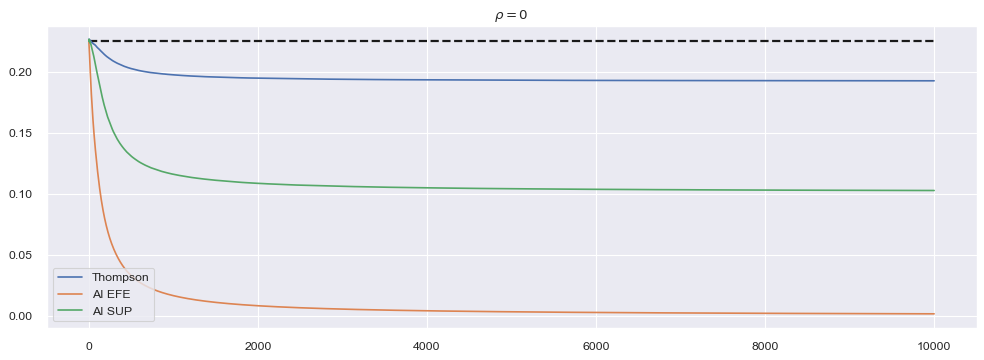

In [91]:
labels = ['Thompson', 'AI EFE', 'AI SUP']
for sequence, label in zip([sequence1, sequence2, sequence3], labels):
    correct = (sequence['states'] == sequence['choices']).astype(np.float32)
    regret = eps * (1 - correct)

    ts = np.arange(1, T+1)

    plt.plot(regret.cumsum(0).mean(-1)/ts, label=label);

plt.hlines(pars['eps']*(1-1/K), 1, T+1, 'k', linestyle='--', lw=2)
plt.legend()
plt.title(r'$\rho=0$');

In [96]:
pars = {
    'eps': .25, 
    'rho': .001, 
    'base': .5, 
    'pc': np.array([.05, .95]), 
    'gamma': 10.
}

N=1000
T=10000
K=10

sim = Simulator(process, learning, thompson_selection, pars, N=N, T=T, K=K)
sequence1 = sim.run()

sim = Simulator(process, learning, efe_selection, pars, N=N, T=T, K=K)
sequence2 = sim.run()

sim = Simulator(process, learning, sup_selection, pars, N=N, T=T, K=K)
sequence3 = sim.run()

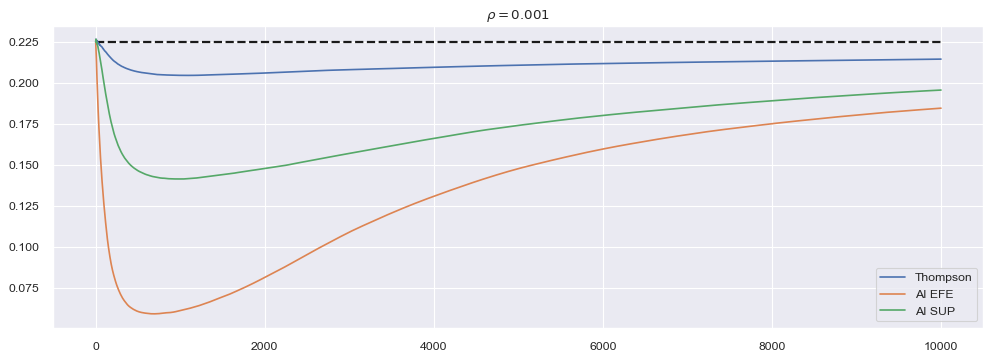

In [97]:
labels = ['Thompson', 'AI EFE', 'AI SUP']
for sequence, label in zip([sequence1, sequence2, sequence3], labels):
    correct = (sequence['states'] == sequence['choices']).astype(np.float32)
    regret = eps * (1 - correct)

    ts = np.arange(1, T+1)

    plt.plot(regret.cumsum(0).mean(-1)/ts, label=label);

plt.hlines(pars['eps']*(1-1/K), 1, T+1, 'k', linestyle='--', lw=2)
plt.legend()
plt.title(r'$\rho=0.001$');

In [98]:
pars = {
    'eps': .25, 
    'rho': .01, 
    'base': .5, 
    'pc': np.array([.05, .95]), 
    'gamma': 10.
}

N=1000
T=10000
K=10

sim = Simulator(process, learning, thompson_selection, pars, N=N, T=T, K=K)
sequence1 = sim.run()

sim = Simulator(process, learning, efe_selection, pars, N=N, T=T, K=K)
sequence2 = sim.run()

sim = Simulator(process, learning, sup_selection, pars, N=N, T=T, K=K)
sequence3 = sim.run()

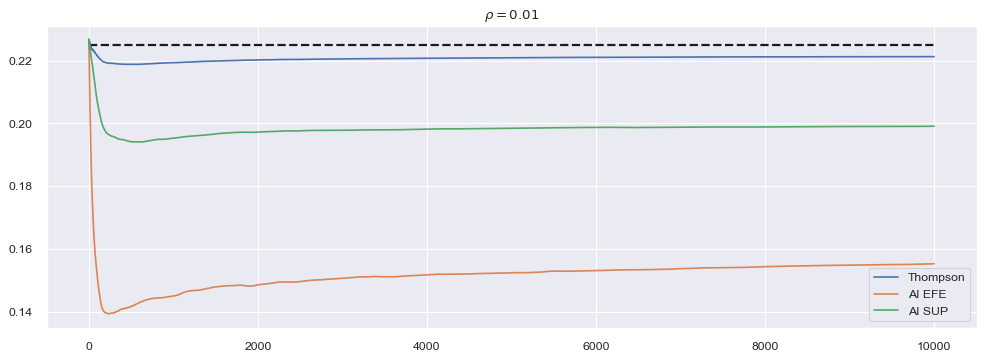

In [99]:
labels = ['Thompson', 'AI EFE', 'AI SUP']
for sequence, label in zip([sequence1, sequence2, sequence3], labels):
    correct = (sequence['states'] == sequence['choices']).astype(np.float32)
    regret = eps * (1 - correct)

    ts = np.arange(1, T+1)

    plt.plot(regret.cumsum(0).mean(-1)/ts, label=label);

plt.hlines(pars['eps']*(1-1/K), 1, T+1, 'k', linestyle='--', lw=2)
plt.legend()
plt.title(r'$\rho=0.01$');

In [100]:
pars = {
    'eps': .25, 
    'rho': .1, 
    'base': .5, 
    'pc': np.array([.05, .95]), 
    'gamma': 10.
}

N=1000
T=10000
K=10

sim = Simulator(process, learning, thompson_selection, pars, N=N, T=T, K=K)
sequence1 = sim.run()

sim = Simulator(process, learning, efe_selection, pars, N=N, T=T, K=K)
sequence2 = sim.run()

sim = Simulator(process, learning, sup_selection, pars, N=N, T=T, K=K)
sequence3 = sim.run()

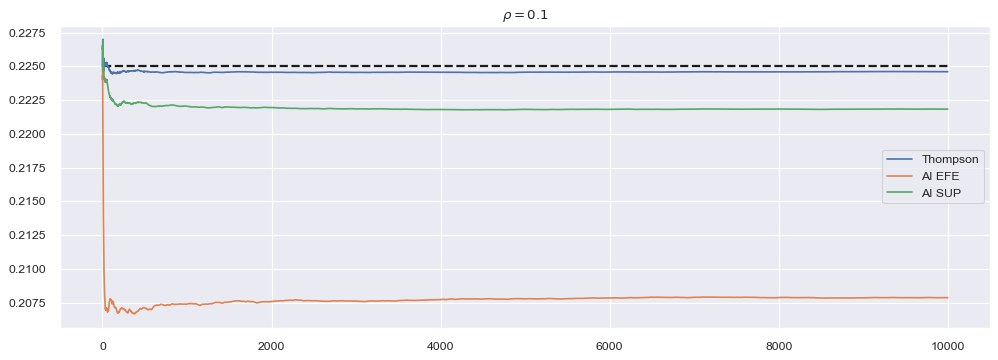

In [102]:
labels = ['Thompson', 'AI EFE', 'AI SUP']
for sequence, label in zip([sequence1, sequence2, sequence3], labels):
    correct = (sequence['states'] == sequence['choices']).astype(np.float32)
    regret = eps * (1 - correct)

    ts = np.arange(1, T+1)

    plt.plot(regret.cumsum(0).mean(-1)/ts, label=label);

plt.hlines(pars['eps']*(1-1/K), 1, T+1, 'k', linestyle='--', lw=2)
plt.legend()
plt.title(r'$\rho=0.1$');